In [2]:
import geopandas as gpd # Geospatial data operations
import rasterio as rio # Geospatial imagery manipulation
import rasterio.plot
import pandas as pd # Tabular data
import os
import re
import rapidfuzz # Fuzzy string matching
from tqdm.auto import tqdm # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map # Parallel operations
import matplotlib # Plots
import matplotlib.pyplot as plt
import shapely # Polygon operations
#import solaris.tile as tile # Tile splitting
#import solaris.data.coco as coco
import contextlib
import io
import rasterio # Raster imagery operations
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.merge import merge # Merging tiles into mosaics
from glob import glob # Finding files
from shapely.geometry import box # Bounding box operations
matplotlib.rcParams['figure.figsize'] = (20, 10)
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

## Match shapefiles to images

In [3]:
# A complete filelist of the MaxarImagery & Retrolens folders, generated with the unix command:
# find MaxarImagery/ Retrolens/ > ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt
filelist = pd.read_csv("ressci201900060-RNC2-Coastal/Nick/ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
152982    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
152983    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
152984    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
152985        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
152986                                   Retrolens/Wellington/MasterBlank_withProxy.shx
Name: 0, Length: 152987, dtype: 

In [4]:
def check_filename(filename):
    # This regex only matches shapefiles that contain something date-like in their names
    match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
    return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
341,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp
344,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_29JAN2011.shp
355,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_25DEC2015.shp
362,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_08NOV2019.shp
366,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_03NOV2013.shp
...,...
151567,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp
151569,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp
151572,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp
151626,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp


In [5]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

252       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
253       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
255         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
258         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
272         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
152968            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
152974            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
152977            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
152978            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
152981            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 2416, dtype: ob

In [6]:
# When fuzzy matching, ignore these strings
# _0 will ignore leading zeros in dates
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", ".mosaic", "_cliff", "_beach", "_beachcliffsegment", "_MF.shp", "_MT.shp", "_0", "_1.tif", "_2.tif", "_3.tif", "_LDS", "_"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print("Perfect matches:", sum(df.match_score == 100))
print("Imperfect matches:", sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

Perfect matches: 1358
Imperfect matches: 352


In [7]:
df = df[df.match_score >= 100].sort_values(by="match_score")
df

,filename,matched_image,match_score
341,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif,100.0
108218,Retrolens/Tasman/Motueka/Shorelines/Motueka_22SEP1969.shp,Retrolens/Tasman/Motueka/Stack/Motueka_22SEP1969_mosaic.jp2,100.0
108217,Retrolens/Tasman/Motueka/Shorelines/Motueka_27MAR1947.shp,Retrolens/Tasman/Motueka/Stack/Motueka_27MAR1947_mosaic.jp2,100.0
108216,Retrolens/Tasman/Motueka/Shorelines/Motueka_19MAY1958.shp,Retrolens/Tasman/Motueka/Stack/Motueka_19MAY1958_mosaic.jp2,100.0
107898,Retrolens/Tasman/ TorrentBay/Shorelines/TorrentBay_09APR1965.shp,Retrolens/Tasman/ TorrentBay/Stack/TorrentBay_09APR1965_mosaic.jp2,100.0
...,...,...,...
42022,MaxarImagery/HighFreq/Gisborne/Wainui/Shorelines/Wainui_31AUG2005.shp,MaxarImagery/HighFreq/Gisborne/Wainui/Imagery/Stack/Wainui_31AUG2005.tif,100.0
41679,MaxarImagery/HighFreq/Gisborne/TeAraroa/Shorelines/TeAraroa_20FEB2016.shp,MaxarImagery/HighFreq/Gisborne/TeAraroa/Imagery/Stack/TeAraroa_20FEB2016.tif,100.0
41670,MaxarImagery/HighFreq/Gisborne/TeAraroa/Shorelines/TeAraroa_02JAN2010.shp,MaxarImagery/HighFreq/Gisborne/TeAraroa/Imagery/Stack/TeAraroa_02JAN2010.tif,100.0
42341,MaxarImagery/HighFreq/Gisborne/WaipiroBay/Shorelines/WaipiroBay_12MAR2018.shp,MaxarImagery/HighFreq/Gisborne/WaipiroBay/Imagery/Stack/WaipiroBay_12MAR2018.tif,100.0


## Investigate metadata about the matched images

In [9]:
def get_meta(tup):
    i, row = tup
    image = rio.open("ressci201900060-RNC2-Coastal/" + row.matched_image)
    gdf = gpd.read_file("ressci201900060-RNC2-Coastal/" + row.filename)
    row = row.to_dict()
    row["n_lines"] = len(gdf.explode(index_parts=False))
    row.update(image.profile)
    row["GCPs"] = len(image.gcps[0])
    row["res"] = image.res
    row["CPS"] = "CPS" in gdf.columns
    return row

metafile = "meta.csv"
if os.path.isfile(metafile):
    meta = pd.read_csv(metafile)
else:
    meta = pd.DataFrame(process_map(get_meta, df.iterrows(), total=len(df)))
    meta.to_csv(metafile, index=False)
meta

  0%|          | 0/1358 [00:00<?, ?it/s]

,filename,matched_image,match_score,n_lines,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,CPS,photometric
0,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif,100.0,2,GTiff,uint8,NaN,3975,12039,3,None,"(0.6, 0.0, 2022707.1257145917, 0.0, -0.5999999999999536, 5670278.448431859, 0.0, 0.0, 1.0)",128.0,128,True,lzw,pixel,26,"(0.6, 0.5999999999999536)",False,NaN
1,Retrolens/Tasman/Motueka/Shorelines/Motueka_22SEP1969.shp,Retrolens/Tasman/Motueka/Stack/Motueka_22SEP1969_mosaic.jp2,100.0,12,JP2OpenJPEG,uint16,2.560000e+02,7772,12373,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(0.699999999999988, 0.0, 1598711.5993977117, 0.0, -0.6999999999999699, 5457279.240833512, 0.0, 0.0, 1.0)",1024.0,1024,True,NaN,pixel,0,"(0.699999999999988, 0.6999999999999699)",True,NaN
2,Retrolens/Tasman/Motueka/Shorelines/Motueka_27MAR1947.shp,Retrolens/Tasman/Motueka/Stack/Motueka_27MAR1947_mosaic.jp2,100.0,6,JP2OpenJPEG,uint16,2.560000e+02,8806,13153,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(0.5500000000000053, 0.0, 1598643.426917212, 0.0, -0.5500000000000284, 5456395.98187636, 0.0, 0.0, 1.0)",1024.0,1024,True,NaN,pixel,0,"(0.5500000000000053, 0.5500000000000284)",True,NaN
3,Retrolens/Tasman/Motueka/Shorelines/Motueka_19MAY1958.shp,Retrolens/Tasman/Motueka/Stack/Motueka_19MAY1958_mosaic.jp2,100.0,7,JP2OpenJPEG,uint16,2.560000e+02,5734,8279,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(1.25, 0.0, 1596592.4215778385, 0.0, -1.25, 5456849.980064916, 0.0, 0.0, 1.0)",1024.0,1024,True,NaN,pixel,0,"(1.25, 1.25)",True,NaN
4,Retrolens/Tasman/ TorrentBay/Shorelines/TorrentBay_09APR1965.shp,Retrolens/Tasman/ TorrentBay/Stack/TorrentBay_09APR1965_mosaic.jp2,100.0,15,JP2OpenJPEG,uint16,2.560000e+02,3314,12191,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(0.7633183777172683, 0.0, 1603372.3951403194, 0.0, -0.7633183777172489, 5475018.833818431, 0.0, 0.0, 1.0)",1024.0,1024,True,NaN,pixel,0,"(0.7633183777172683, 0.7633183777172489)",True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,MaxarImagery/HighFreq/Gisborne/Wainui/Shorelines/Wainui_31AUG2005.shp,MaxarImagery/HighFreq/Gisborne/Wainui/Imagery/Stack/Wainui_31AUG2005.tif,100.0,0,GTiff,uint8,NaN,12279,11845,3,None,"(0.5999999999999924, 0.0, 2040756.677038667, 0.0, -0.6, 5710313.147996475, 0.0, 0.0, 1.0)",128.0,128,True,lzw,pixel,6,"(0.5999999999999924, 0.6)",False,NaN
1354,MaxarImagery/HighFreq/Gisborne/TeAraroa/Shorelines/TeAraroa_20FEB2016.shp,MaxarImagery/HighFreq/Gisborne/TeAraroa/Imagery/Stack/TeAraroa_20FEB2016.tif,100.0,5,GTiff,uint8,NaN,15205,10841,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(0.37970030307769775, 0.0, 2069262.7143920655, 0.0, -0.37970030307769775, 5825334.13395847, 0.0, 0.0, 1.0)",128.0,128,True,lzw,pixel,0,"(0.37970030307769775, 0.37970030307769775)",False,NaN
1355,MaxarImagery/HighFreq/Gisborne/TeAraroa/Shorelines/TeAraroa_02JAN2010.shp,MaxarImagery/HighFreq/Gisborne/TeAraroa/Imagery/Stack/TeAraroa_02JAN2010.tif,100.0,3,GTiff,uint8,NaN,11547,8233,3,"(proj, lat_0, lon_0, k, x_0, y_0, ellps, towgs84, units, no_defs)","(0.5, 0.0, 2069262.4598055382, 0.0, -0.5, 5825334.395660261, 0.0, 0.0, 1.0)",128.0,128,True,lzw,pixel,0,"(0.5, 0.5)",False,NaN
1356,MaxarImagery/HighFreq/Gisborne/WaipiroBay/Shorelines/WaipiroBay_12MAR2018.shp,MaxarImagery/HighFreq/Gisborne/WaipiroBay/Imagery/Stack/WaipiroBay_12MAR2018.tif,100.0,5,GTiff,uint8,NaN,7107,12427,3,None,"(0.5, 0.0, 2068022.8322112106, 0.0, -0.5, 5782444.209548346, 0.0, 0.0, 1.0)",128.0,128,True,lzw,pixel,3,"(0.5, 0.5)",False,NaN


In [10]:
meta.crs.value_counts(dropna=False)

PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2193"]]                          622
NaN                                                                                                                                                                                                                                                                                                                                           

In [11]:
meta.GCPs.value_counts()

True    898
Name: GCPs, dtype: int64

In [12]:
meta.columns

Index(['filename', 'matched_image', 'match_score', 'n_lines', 'driver',
       'dtype', 'nodata', 'width', 'height', 'count', 'crs', 'transform',
       'blockxsize', 'blockysize', 'tiled', 'compress', 'interleave', 'GCPs',
       'photometric'],
      dtype='object')

In [13]:
meta.driver.value_counts()

JP2OpenJPEG    608
GTiff          289
JPEG             1
Name: driver, dtype: int64

In [14]:
meta["count"].value_counts()

3    838
1     59
4      1
Name: count, dtype: int64

In [15]:
meta.dtype.value_counts()

uint16    596
uint8     288
int32      14
Name: dtype, dtype: int64

In [16]:
meta.nodata.value_counts()

2.560000e+02    596
2.147484e+09     14
2.550000e+02      2
Name: nodata, dtype: int64

## Make mosaics for LINZ images

In [14]:
maybe_LDS = df[(df.match_score < 100) & df.filename.str.startswith("Retrolens")].copy()
maybe_LDS

,filename,matched_image,match_score
46010,Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_16JAN2019_NEL18R.shp,Retrolens/Nelson/BoulderBank/Stack/BoulderBank_13JAN2000_mosaic.jp2,73.913043
46231,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_18NOV2005.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_17JAN1957_mosaic.jp2,72.727273
46232,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_27SEP2017.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_22SEP1969_mosaic.jp2,81.818182
46294,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_31JAN2021.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_17JAN1957_mosaic.jp2,81.818182
46300,Retrolens/Nelson/Glenduan_North/Shorelines/Glenduan_North_30DEC2015.shp,Retrolens/Nelson/Glenduan_North/Stack/Glenduan_North_20NOV1983_mosaic.jp2,72.727273
...,...,...,...
138939,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_27APR2020.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_17APR1952_mosaic.tif,80.000000
138969,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_15MAR2017.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_15APR1966_mosaic.tif,80.000000
139007,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_04APR2014.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_28APR1948_mosaic.tif,82.051282
139012,Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_04MAR2010.shp,Retrolens/Wellington/KapitiNorth/Stack/NorthKapiti_24MAR1970_mosaic.tif,87.179487


In [15]:
if not os.path.isfile("maybe_LDS.csv"):
    maybe_LDS.filename.to_csv("maybe_LDS.csv", index=False)

## Match shapefiles with the corresponding index tiles shapefile
- First get the bounds of every tile
- Tiles that spatially match the bounds of a drawn EOV shapefile will be used to create the corresponding mosaic

In [16]:
if os.path.isfile("tilelist.parquet"):
    tilelist = gpd.read_parquet("tilelist.parquet")
else:
    tilelist = pd.DataFrame({"filename": glob("DigitalJPGs/**/*.jpg", recursive=True)})
    tilelist["region"] = tilelist.filename.str.split("/").str[1]
    tilelist["tilename"] = tilelist.filename.str.split("/").str[-1].str.replace(".jpg", "")
    def get_bounds(f):
        return rio.open(f).bounds
    tilelist["bounds"] = thread_map(get_bounds, tilelist.filename)
    tilelist.bounds = tilelist.bounds.progress_apply(lambda b: box(*b))
    tilelist = gpd.GeoDataFrame(tilelist, geometry="bounds")
    tilelist.to_parquet("tilelist.parquet")

In [17]:
# This cell might useful for finding matches, based on geospatial correlation
for filename in tqdm(maybe_LDS.filename):
    break
    df = gpd.read_file(filename)
    if len(df) == 0:
        continue
    bounds = df.total_bounds
    intersecting_tiles = tilelist[tilelist.intersects(box(*bounds))]
    print(f"{filename} matches:\n\t{len(intersecting_tiles)} tiles from:\n\t\t{intersecting_tiles.filename}")

  0%|          | 0/108 [00:00<?, ?it/s]


In [18]:
LDS = pd.read_csv("maybe_LDS.csv").dropna()
LDS

,filename,matched_tile_root
0,Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_16JAN2019_NEL18R.shp,DigitalJPGs/Nelson/NEL18R
18,Retrolens/Auckland/Whatipu/Shorelines/Whatipu_07APR2010.shp,DigitalJPGs/Auckland/Auckland 2010R
22,Retrolens/Auckland/Omaha/Shorelines/Omaha_04DEC2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
23,Retrolens/Auckland/PakiriBeach_North/Shorelines/PakiriBeach_North_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
24,Retrolens/Auckland/TeArai/Shorelines/TeArai_06NOV2015.shp,DigitalJPGs/Northland/Northland 0.40m Rural Aerial Photos 2014-16
25,Retrolens/Auckland/Orewa/Shorelines/Orewa_08MAR2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
26,Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_04MAR2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012
27,Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_03JAN2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011
31,Retrolens/Otago/Ryans_Pipikaretu_Penguin_TeRauoneBeach/Stack/Shorelines/Ryans_Pipikaretu_Penguin_TeRauoneBeach_29JAN2019.shp,DigitalJPGs/Otago/otago-03m-rural-aerial-photos-2017-2019
36,Retrolens/Otago/Tautuku_Beach/Shorelines/Tautuku_02May2013.shp,DigitalJPGs/Southland/STH13R


For each file, create a mosaic from the corresponding tiles

In [52]:
done = LDS.filename.apply(lambda f: os.path.isfile(f.replace(".shp", ".tif")))
display(done.value_counts(dropna=False))

for i, row in tqdm(LDS[~done].iterrows(), total=len(LDS[~done])):
    filename = row.filename
    mosaic_filename = filename.replace(".shp", ".tif")
    shapefile = gpd.read_file(filename)
    bounds = shapefile.total_bounds
    intersecting_tiles = tilelist[tilelist.intersects(box(*bounds)) & tilelist.filename.str.startswith(row.matched_tile_root)]
    tiles = list(intersecting_tiles.filename)
    print(len(tiles))
    Z, transform = merge(tiles)
    with rasterio.open(
        mosaic_filename,
        'w',
        driver='GTiff',
        height=Z.shape[1],
        width=Z.shape[2],
        count=Z.shape[0],
        dtype=Z.dtype,
        crs=shapefile.crs,
        transform=transform,
        compress='lzw',
        BIGTIFF = "IF_SAFER"
    ) as dst:
        dst.write(Z)

True     52
False     4
Name: filename, dtype: int64

  0%|          | 0/4 [00:00<?, ?it/s]

2


 25%|██▌       | 1/4 [00:24<01:14, 24.70s/it]

1


 50%|█████     | 2/4 [00:34<00:31, 15.87s/it]

3


 75%|███████▌  | 3/4 [01:13<00:26, 26.42s/it]

4


100%|██████████| 4/4 [01:59<00:00, 29.86s/it]


In [20]:
LDS["matched_image"] = LDS.filename.str.replace(".shp", ".tif")
LDS[done].to_csv("LDS_matches.csv", index=False)

/tmp/ipykernel_2231035/3578432877.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  LDS["matched_image"] = LDS.filename.str.replace(".shp", ".tif")


In [40]:
metafile = "LDS_meta.csv"
if os.path.isfile(metafile):
    meta = pd.read_csv(metafile)
else:
    meta = pd.DataFrame(LDS.progress_apply(get_meta, axis=1).tolist())
    meta.to_csv(metafile, index=False)
meta[meta.crs.isna()]

,filename,matched_tile_root,matched_image,n_lines,driver,dtype,nodata,width,height,count,crs,transform,blockysize,tiled,compress,interleave,GCPs
2,Retrolens/Auckland/Omaha/Shorelines/Omaha_04DEC2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012,Retrolens/Auckland/Omaha/Shorelines/Omaha_04DEC2012.tif,1,GTiff,uint8,NaN,19200,14400,3,NaN,"| 0.50, 0.00, 1756000.00|\n| 0.00,-0.50, 5982000.00|\n| 0.00, 0.00, 1.00|",1,False,lzw,pixel,0
5,Retrolens/Auckland/Orewa/Shorelines/Orewa_08MAR2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011,Retrolens/Auckland/Orewa/Shorelines/Orewa_08MAR2011.tif,11,GTiff,uint8,NaN,9600,14400,3,NaN,"| 0.50, 0.00, 1751200.00|\n| 0.00,-0.50, 5953200.00|\n| 0.00, 0.00, 1.00|",1,False,lzw,pixel,0
6,Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_04MAR2012.shp,DigitalJPGs/Auckland/RNC2 Auckland/2012,Retrolens/Auckland/PakiriBeach/Shorelines/PakiriBeach_04MAR2012.tif,6,GTiff,uint8,NaN,19200,28800,3,NaN,"| 0.50, 0.00, 1751200.00|\n| 0.00,-0.50, 5996400.00|\n| 0.00, 0.00, 1.00|",1,False,lzw,pixel,0
7,Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_03JAN2011.shp,DigitalJPGs/Auckland/RNC2 Auckland/2011,Retrolens/Auckland/KawakawaBay/Shorelines/KawakawaBay_03JAN2011.tif,8,GTiff,uint8,NaN,19200,28800,3,NaN,"| 0.50, 0.00, 1789600.00|\n| 0.00,-0.50, 5917200.00|\n| 0.00, 0.00, 1.00|",1,False,lzw,pixel,0


### Algorithm for converting polyline shapefile to polygon annotations, labelled as sea or land

In [21]:
coastline = gpd.read_file("lds-nz-coastlines-and-islands-polygons-topo-150k-FGDB.zip!nz-coastlines-and-islands-polygons-topo-150k.gdb")

In [26]:
# Get a random (known-good) annotation
sample = LDS.sample(1)
display(sample)
image_filename = sample.matched_image.iloc[0]
image = rio.open(image_filename)
sample_gdf = gpd.read_file(sample.filename.iloc[0])
sample_gdf

,filename,matched_tile_root,matched_image
65,Retrolens/WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_11FEB2016.shp,DigitalJPGs/WestCoast/WST15R,Retrolens/WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_11FEB2016.tif


,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,geometry
0,0,WestCoast,WhareateaRiver,2016-02-11,11/02/2016,ER,1000,NaN,LDS,"LINESTRING (1489923.583 5378448.031, 1489914.058 5378453.852, 1489909.560 5378455.439, 1489898.183 5378458.350, 1489888.658 53..."
1,0,WestCoast,WhareateaRiver,2016-02-11,11/02/2016,ER,1000,NaN,LDS,"LINESTRING (1492639.801 5380247.995, 1492651.443 5380256.991, 1492656.735 5380261.224, 1492671.287 5380270.485, 1492678.695 53..."
2,0,WestCoast,WhareateaRiver,2016-02-11,11/02/2016,ER,1000,NaN,LDS,"LINESTRING (1493510.365 5380578.311, 1493505.073 5380584.661, 1493501.475 5380588.895, 1493493.220 5380593.551, 1493483.483 53..."


In [27]:
def line_to_split_bbox(geo):
    bounding_box = geo.envelope
    split_bbox = shapely.ops.split(bounding_box, geo)
    return split_bbox

split_bboxes = sample_gdf.geometry.apply(line_to_split_bbox).explode(index_parts=True).reset_index()
#split_bboxes.geometry = split_bboxes.geometry.buffer(0)
split_bboxes["area"] = split_bboxes.area
split_bboxes = split_bboxes[split_bboxes.area > 1e5]
split_bboxes

,level_0,level_1,geometry,area
1,0,1,"POLYGON ((1492639.801 5380247.995, 1492639.801 5378448.031, 1489923.583 5378448.031, 1489914.058 5378453.852, 1489909.560 5378...",2.500458e+06
2,0,2,"POLYGON ((1489850.558 5378493.539, 1489850.558 5380247.995, 1492639.801 5380247.995, 1492630.276 5380244.291, 1492611.755 5380...",2.519222e+06
3,1,0,"POLYGON ((1493376.667 5380561.527, 1493376.667 5380247.995, 1492639.801 5380247.995, 1492651.443 5380256.991, 1492656.735 5380...",1.699820e+05
7,2,1,"POLYGON ((1495740.542 5382876.116, 1495740.542 5380578.311, 1493510.365 5380578.311, 1493505.073 5380584.661, 1493501.475 5380...",3.113896e+06
9,2,3,"POLYGON ((1493441.785 5380631.863, 1493441.785 5382904.162, 1495654.817 5382904.162, 1495641.588 5382903.898, 1495630.211 5382...",2.230611e+06


In [28]:
relevant_coastline = coastline.clip(split_bboxes.total_bounds)
split_bboxes["area_inland"] = split_bboxes.clip(relevant_coastline).area
split_bboxes["fraction_inland"] = split_bboxes.area_inland / split_bboxes.area
split_bboxes["class"] = split_bboxes.fraction_inland.apply(lambda f: "land" if f > .5 else "sea")
split_bboxes

,level_0,level_1,geometry,area,area_inland,fraction_inland,class
1,0,1,"POLYGON ((1492639.801 5380247.995, 1492639.801 5378448.031, 1489923.583 5378448.031, 1489914.058 5378453.852, 1489909.560 5378...",2.500458e+06,2.500458e+06,1.000000,land
2,0,2,"POLYGON ((1489850.558 5378493.539, 1489850.558 5380247.995, 1492639.801 5380247.995, 1492630.276 5380244.291, 1492611.755 5380...",2.519222e+06,2.593593e+05,0.102952,sea
3,1,0,"POLYGON ((1493376.667 5380561.527, 1493376.667 5380247.995, 1492639.801 5380247.995, 1492651.443 5380256.991, 1492656.735 5380...",1.699820e+05,1.699820e+05,1.000000,land
7,2,1,"POLYGON ((1495740.542 5382876.116, 1495740.542 5380578.311, 1493510.365 5380578.311, 1493505.073 5380584.661, 1493501.475 5380...",3.113896e+06,3.113896e+06,1.000000,land
9,2,3,"POLYGON ((1493441.785 5380631.863, 1493441.785 5382904.162, 1495654.817 5382904.162, 1495641.588 5382903.898, 1495630.211 5382...",2.230611e+06,1.504236e+05,0.067436,sea


(5378448.031009706, 5382904.162343841)

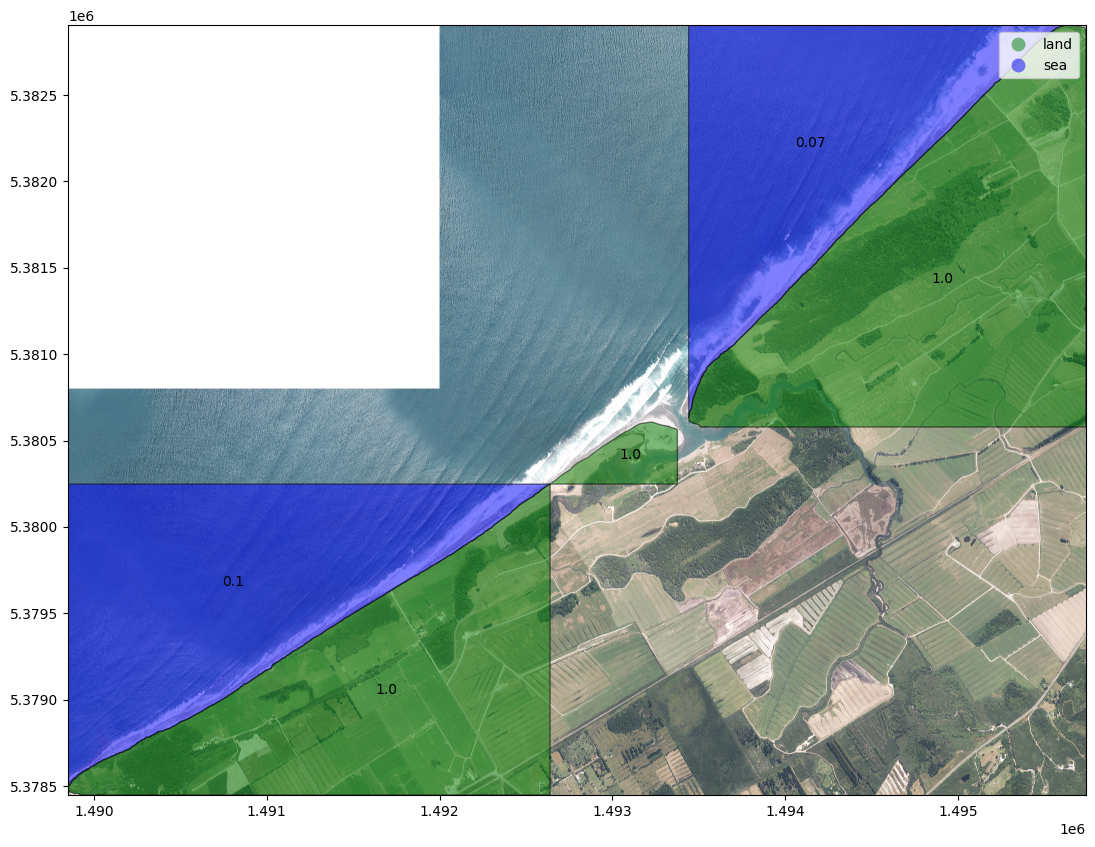

In [29]:
# Plot the results, and check it all looks ok
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
split_bboxes.plot(ax=ax, alpha=.5, column='class', cmap=cmap, categorical=True, legend=True, edgecolor='black')
split_bboxes.apply(lambda x: ax.annotate(text=round(x.fraction_inland, 2), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

#relevant_coastline.plot(ax=ax, alpha=.5, edgecolor="cyan")

b = split_bboxes.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)